# Round 3 verification 

In [1]:
import os
import sys
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/')) # Assuming the DummyDataGenerator is defined in a module

import numpy as np
import pandas as pd
from  round3_op_implementation import ProjectAllocator
from model.DummyDataGenerator import DummyDataGenerator 
from model.VotingRules import VotingRules

# Constants for allocation
QUORUM = 17
MIN_AMOUNT = 1500
TOTAL_AMOUNT = 30000000

# Generate dummy data

generator = DummyDataGenerator(
    num_rows=100,  # Number of rows (voters) to generate
    max_project_in_ballot=5,  # Maximum projects a voter can vote for
    max_votes=3,  # Maximum votes a voter can cast
    start_date="2023-01-01",  # Start date for random timestamps
    end_date="2023-12-31"  # End date for random timestamps
)

# Generate the DataFrame
df = generator.generate_dummy_data()

# Expand the 'Votes' column and format the DataFrame for ProjectAllocator
df_votes_expanded = df.explode('Votes').reset_index(drop=True)
df_votes_expanded = pd.concat(
    [df_votes_expanded.drop(['Votes'], axis=1), df_votes_expanded['Votes'].apply(pd.Series)],
    axis=1
)
df_votes_expanded = df_votes_expanded.rename(columns={
    "projectId": "project_id",
    "amount": "amount",
    "Address": "voter_address"
})
df_votes_expanded["amount"] = df_votes_expanded["amount"].astype(float)  # Ensure amount is a float

# Instantiate the allocator and calculate initial and scaled allocations
allocator = ProjectAllocator(TOTAL_AMOUNT, MIN_AMOUNT, QUORUM)
initial_allocation = allocator.calculate_initial_allocation(df_votes_expanded)
print('Initial_Allocation')
print(initial_allocation)

scaled_allocation = allocator.scale_allocations(initial_allocation, "median_amount")
print('Scaled_Allocation')
print(scaled_allocation)

# Now let's use your VotingRules class to calculate the allocation using the median rule
voting_matrix = df_votes_expanded.pivot_table(
    index='voter_address', columns='project_id', values='amount', fill_value=0
).values


num_voters = voting_matrix.shape[0]
total_op_tokens = TOTAL_AMOUNT  # Equivalent to total funds in this context


voting_rules = VotingRules()
median_allocation = voting_rules.r3_median(voting_matrix, total_op_tokens, num_voters)

comparison_df = pd.DataFrame({
    'Allocation (ProjectAllocator)': scaled_allocation['scaled_amount'].values,
    'Allocation (Our Implemenation)': median_allocation
})
print('Comparison_Allocation')
comparison_df.head()

2024-09-30 11:20:47 INFO | Check - If all are eligible: False
2024-09-30 11:20:47 INFO | Check - Original Amount Eligible: 14207839.5
2024-09-30 11:20:47 INFO | Check - Scale Factor: 2.111510339063163
2024-09-30 11:20:47 INFO | Check - New Amount Eligible: 29999999.999999996


Initial_Allocation
            votes_count  median_amount  is_eligible
project_id                                         
proj0                24      2755795.0         True
proj1                16      2863746.5        False
proj2                19      2936279.0         True
proj3                15      3546360.0        False
proj4                22      2105659.0         True
Scaled_Allocation
            votes_count  median_amount  is_eligible  scaled_amount
project_id                                                        
proj0                24      2755795.0         True   5.818890e+06
proj1                16      2863746.5        False   6.046830e+06
proj2                19      2936279.0         True   6.199983e+06
proj3                15      3546360.0        False   7.488176e+06
proj4                22      2105659.0         True   4.446121e+06
Comparison_Allocation


,Allocation (ProjectAllocator),Allocation (Our Implemenation)
0,5.818890e+06,5.818890e+06
1,6.046830e+06,6.046830e+06
2,6.199983e+06,6.199983e+06
3,7.488176e+06,7.488176e+06
4,4.446121e+06,4.446121e+06


# Round 2 Verification

In [2]:
import numpy as np

# Define the voting matrix
voting_matrix = np.array([[50, 10, 40, 0],
                          [10, 50, 20, 20],
                          [0, 50, 0, 50],
                          [0, 100, 0, 0],
                          [40, 20, 20, 20]])
total_op_tokens=10e6
num_voters=5

voting_rules = VotingRules()
mean_allocation = voting_rules.r2_mean(voting_matrix, total_op_tokens, num_voters)
print(mean_allocation)

[2000000. 4600000. 1600000. 1800000.]


# Round 1 Verification

In [2]:
final_file_path = '/Users/idrees/Code/govxs/data/historic_data/Final_Cleaned_RetroPGF_Data.csv'
data = pd.read_csv(final_file_path)

# Drop the first column
data = data.drop(data.columns[0], axis=1)
data.fillna(0, inplace=True)

data.head(10)

funds=1000000
calculated_allocation=voting_rules.r1_quadratic(data,funds,num_voters)

# Load the CSV file
file_path = '/Users/idrees/Code/govxs/data/retropgf_r1_data.csv'
real_data = pd.read_csv(file_path)
real_data.fillna(0, inplace=True)

# Extract the row and remove the first two columns by their names
actual_allocation = real_data.iloc[26].drop(['Unnamed: 0', 'Unnamed: 1'])

# Convert values to integers
actual_allocation = actual_allocation.apply(lambda x: int(str(x).replace('$', '').replace(',', '').strip()) if pd.notna(x) and str(x).replace('$', '').replace(',', '').strip().isdigit() else 0)

# Assuming 'calculated_allocation' is already defined as your calculated results


# Create a new dataframe with both actual and calculated allocations
allocations_df = pd.DataFrame({
    'Actual Allocations': actual_allocation.values,
    'Calculated Allocations': calculated_allocation.values
})

allocations_df['Absolute Difference'] = (allocations_df['Actual Allocations'] - allocations_df['Calculated Allocations']).abs()
allocations_df['Percentage Difference'] = (allocations_df['Absolute Difference'] / allocations_df['Actual Allocations']) * 100

# Display the dataframe with differences
allocations_df.head(70)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/idrees/Code/govxs/data/Final_Cleaned_RetroPGF_Data.csv'

       Actual Allocations  Calculated Allocations
count           76.000000               76.000000
mean         13157.776316            13157.894737
std          13175.546557            11748.042362
min              0.000000                0.000000
25%           1222.000000             1726.503630
50%           9168.500000            10842.855373
75%          21087.750000            22233.306708
max          51345.000000            42643.673919


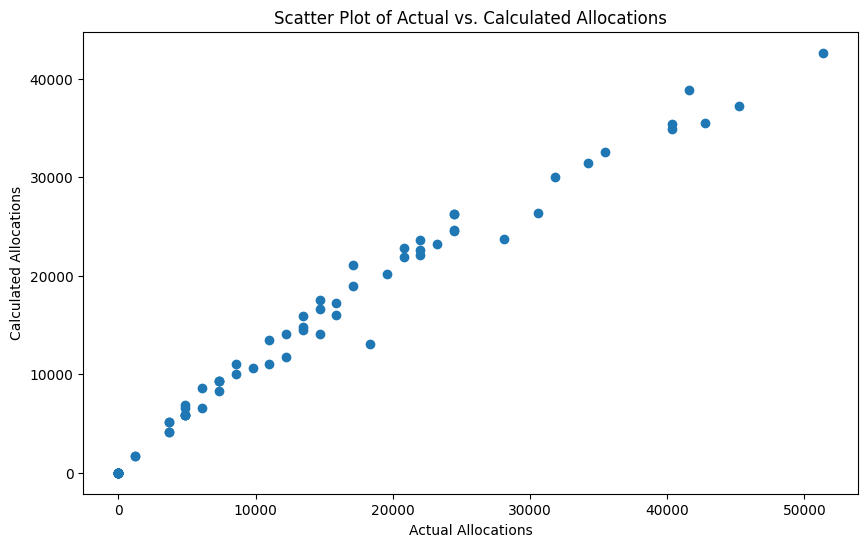

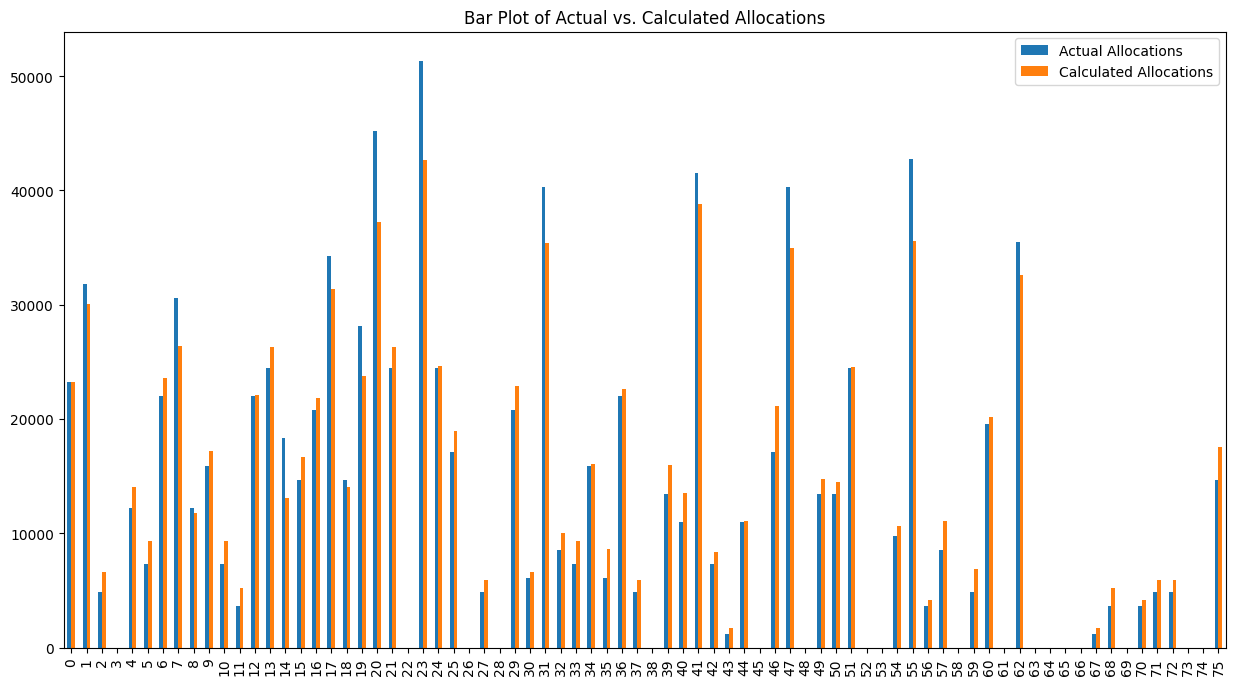

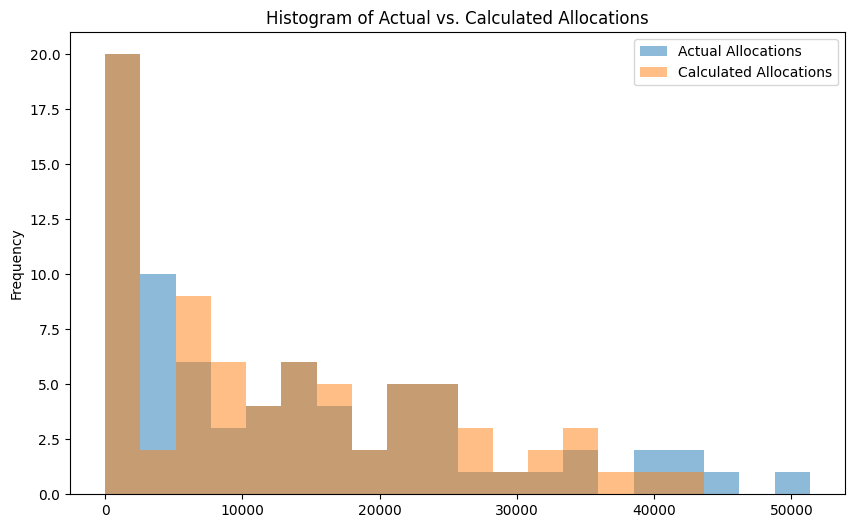

In [9]:
import matplotlib.pyplot as plt

summary_stats = allocations_df[['Actual Allocations', 'Calculated Allocations']].describe()
print(summary_stats)


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(allocations_df['Actual Allocations'], allocations_df['Calculated Allocations'])
plt.xlabel('Actual Allocations')
plt.ylabel('Calculated Allocations')
plt.title('Scatter Plot of Actual vs. Calculated Allocations')
plt.show()

# Bar plot
allocations_df[['Actual Allocations', 'Calculated Allocations']].plot(kind='bar', figsize=(15, 8))
plt.title('Bar Plot of Actual vs. Calculated Allocations')
plt.show()

# Histogram
allocations_df[['Actual Allocations', 'Calculated Allocations']].plot(kind='hist', alpha=0.5, bins=20, figsize=(10, 6))
plt.title('Histogram of Actual vs. Calculated Allocations')
plt.show()
